In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import librosa
import librosa.display
import IPython.display
import os

In [2]:
# Data processing & array operations
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Audio processing
import librosa
import librosa.display

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os
from datetime import datetime
from tqdm import tqdm
import IPython.display

In [3]:
# Cell 1: Import required libraries
import os
import numpy as np
import librosa
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import datetime
import random


In [4]:
import os
import librosa
import numpy as np
from tqdm import tqdm

def load_audio_files(base_path):
    # Dictionary to store audio data and labels
    data = {
        'features': [],
        'labels': []
    }
    
    # Update label mapping to match the new class structure
    label_map = {
        'aedes': 0,
        'anopheles': 1,
        'culex': 2,
        'noise': 3
    }

    # Loop through each class folder
    for class_name in label_map.keys():
        class_path = os.path.join(base_path, class_name)
        
        # Skip if not a directory
        if not os.path.isdir(class_path):
            print(f"Skipping {class_name} as it is not a directory.")
            continue
            
        # Process all `.wav` files in the folder (no subfolders)
        for file in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                try:
                    # Load audio file
                    audio, sr = librosa.load(file_path, sr=16000)  # Resample to 16kHz
                    
                    # Split audio into 1-second windows with a 250 ms stride
                    window_size = sr  # 1 second
                    stride = int(0.25 * sr)  # 250 ms
                    num_windows = (len(audio) - window_size) // stride + 1
                    
                    for i in range(num_windows):
                        start = i * stride
                        end = start + window_size
                        window = audio[start:end]
                        
                        # Generate spectrogram with specified parameters
                        n_fft = int(0.025 * sr)  # Frame length: 25 ms
                        hop_length = int(0.0125 * sr)  # Frame stride: 12.5 ms
                        S = librosa.stft(window, n_fft=n_fft, hop_length=hop_length)
                        S_db = librosa.amplitude_to_db(abs(S), ref=np.max)
                        
                        # Apply noise filtering
                        S_db = np.where(S_db < -52, -52, S_db)
                        
                        # Flatten the spectrogram
                        S_db_flat = S_db.flatten()
                        
                        # Resize/pad if needed to ensure consistent dimensions
                        target_length = 5135  # Match your original input size
                        if len(S_db_flat) > target_length:
                            S_db_flat = S_db_flat[:target_length]
                        elif len(S_db_flat) < target_length:
                            pad_width = target_length - len(S_db_flat)
                            S_db_flat = np.pad(S_db_flat, (0, pad_width))
                            
                        # Add to dataset
                        data['features'].append(S_db_flat)
                        data['labels'].append(label_map[class_name])
                        
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
                    continue

    # Convert to numpy arrays
    X = np.array(data['features'])
    Y = np.array(data['labels'])
    
    return X, Y

# Use the function
base_path = "./datasets/Abuzz_Preprocessed"  # Updated path to your dataset location
X, Y = load_audio_files(base_path)

# Check the shapes
print("Feature matrix shape:", X.shape)
print("Labels shape:", Y.shape)


Processing noise: 100%|██████████| 253/253 [00:04<00:00, 62.98it/s] 


Feature matrix shape: (21837, 5135)
Labels shape: (21837,)


In [5]:
image = X[10]
img_length = image.shape[0]
img_length

5135

In [6]:
# Set the number of columns
columns = 65
rows = int(img_length / columns)
image = np.reshape(image, (rows, columns))
print(image.shape)  # Output should be (125, 41)

(79, 65)


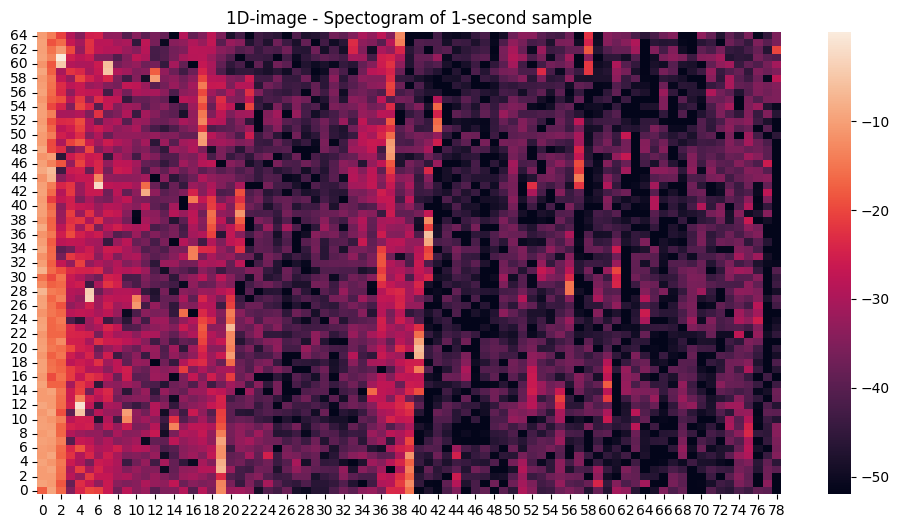

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
#sns.heatmap(image.T)
ax = sns.heatmap(image.T)
ax.invert_yaxis()
plt.title('1D-image - Spectogram of 1-second sample');

In [8]:
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Define the classes
classes_values = ["aedes", "anopheles", "culex", "noise"]
classes = len(classes_values)

# Convert labels to one-hot encoding
Y = tf.keras.utils.to_categorical(Y, classes)

# Split data into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=RANDOM_SEED)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=RANDOM_SEED)

# Prepare the data for training
input_length = X_train[0].shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Check the shapes
print("Training set shape:", X_train.shape, Y_train.shape)
print("Validation set shape:", X_val.shape, Y_val.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: (13102, 5135) (13102, 4)
Validation set shape: (4367, 5135) (4367, 4)
Test set shape: (4368, 5135) (4368, 4)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10)

callbacks = [early_stop]

Train the model:

In [12]:
# MODEL WITH REGULARIZATION

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, SeparableConv1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Model architecture with regularization
model = Sequential()
model.add(Reshape((int(input_length / 65), 65), input_shape=(input_length, )))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)))  # Using Conv1D instead of SeparableConv1D
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(classes, activation='softmax', name='y_pred'))
model.summary()

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 79, 65)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 79, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 40, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y_pred (Dense)                  │ (None, 5)              │         3,205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,037 (109.52 KB)

 Trainable params: 28,037 (109.52 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# MODEL WITH NO REGULARIZATION

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 65), 65), input_shape=(input_length, )))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax', name='y_pred'))
model.summary()

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 79, 65)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 79, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 40, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y_pred (Dense)                  │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,604 (68.77 KB)

 Trainable params: 17,604 (68.77 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
LR = 0.0005
BS = 32
EPOCHS = 100

In [12]:
# this controls the learning rate
opt = Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = BS
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/100
410/410 - 2s - 5ms/step - accuracy: 0.4359 - loss: 2.6846 - val_accuracy: 0.6261 - val_loss: 0.8585
Epoch 2/100
410/410 - 1s - 2ms/step - accuracy: 0.6295 - loss: 0.8601 - val_accuracy: 0.6888 - val_loss: 0.7084
Epoch 3/100
410/410 - 1s - 2ms/step - accuracy: 0.6990 - loss: 0.7026 - val_accuracy: 0.7534 - val_loss: 0.5719
Epoch 4/100
410/410 - 1s - 2ms/step - accuracy: 0.7524 - loss: 0.5921 - val_accuracy: 0.7937 - val_loss: 0.4883
Epoch 5/100
410/410 - 1s - 2ms/step - accuracy: 0.7856 - loss: 0.5200 - val_accuracy: 0.8125 - val_loss: 0.4438
Epoch 6/100
410/410 - 1s - 2ms/step - accuracy: 0.8056 - loss: 0.4778 - val_accuracy: 0.8239 - val_loss: 0.4270
Epoch 7/100
410/410 - 1s - 2ms/step - accuracy: 0.8232 - loss: 0.4335 - val_accuracy: 0.8537 - val_loss: 0.3674
Epoch 8/100
410/410 - 1s - 2ms/step - accuracy: 0.8393 - loss: 0.4011 - val_accuracy: 0.8686 - val_loss: 0.3434
Epoch 9/100
410/410 - 1s - 2ms/step - accuracy: 0.8491 - loss: 0.3768 - val_accuracy: 0.8647 - val_loss:

In [13]:
# Evaluate the model on the test set
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9247 - loss: 0.1958
Test accuracy: 0.9254


In [14]:
import matplotlib.pyplot as plt
def plot_result(history, res= 'loss'):
    plt.plot(history.history[res])
    plt.plot(history.history['val_'+res])
    plt.title(res+' vs. epochs')
    plt.ylabel(res)
    plt.xlabel('Epoch')
    if res == 'loss':
        plt.legend(['Training', res], loc='upper right')
    else:
        plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

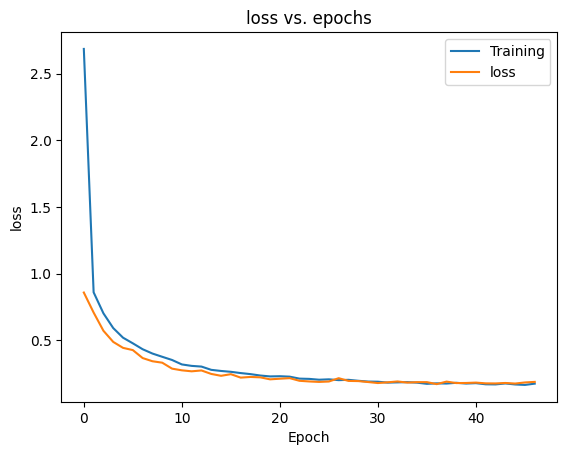

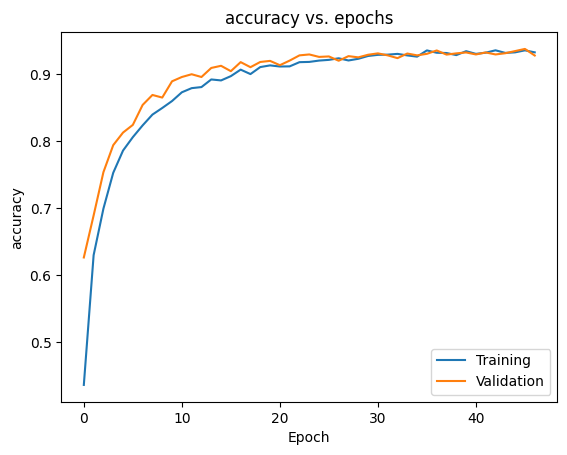

In [15]:
plot_result(history, res= 'loss')
plot_result(history, res= 'accuracy')

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Assuming X_test and Y_test are your test datasets
# Make predictions
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(Y_true, Y_pred_classes, average=None)
recall = recall_score(Y_true, Y_pred_classes, average=None)
f1 = f1_score(Y_true, Y_pred_classes, average=None)
accuracy = accuracy_score(Y_true, Y_pred_classes)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i} - Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}')

# Alternatively, you can use classification_report for a detailed report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred_classes, target_names=['aedes', 'anopheles', 'culex', 'noise']))

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.9254
Class 0 - Precision: 0.9335, Recall: 0.8759, F1 Score: 0.9038
Class 1 - Precision: 0.8791, Recall: 0.9344, F1 Score: 0.9059
Class 2 - Precision: 0.9695, Recall: 0.9905, F1 Score: 0.9799
Class 3 - Precision: 0.9669, Recall: 0.8992, F1 Score: 0.9318

Classification Report:

              precision    recall  f1-score   support

       aedes       0.93      0.88      0.90      1475
   anopheles       0.88      0.93      0.91      1478
       culex       0.97      0.99      0.98      1058
       noise       0.97      0.90      0.93       357

    accuracy                           0.93      4368
   macro avg       0.94      0.93      0.93      4368
weighted avg       0.93      0.93      0.93      4368



In [17]:
# Save the model to disk in HDF5 format
model.save('saved_model.h5')

In [18]:
# Load the model from the HDF5 file
model = tf.keras.models.load_model('saved_model.h5')

In [19]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to disk
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nguye\AppData\Local\Temp\tmpyyd4tbuj\assets


INFO:tensorflow:Assets written to: C:\Users\nguye\AppData\Local\Temp\tmpyyd4tbuj\assets


Saved artifact at 'C:\Users\nguye\AppData\Local\Temp\tmpyyd4tbuj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5135), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2983572653648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2983572654992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2983572654608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2983572655760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2983572654224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2983572657104: TensorSpec(shape=(), dtype=tf.resource, name=None)
